# Starbucks Offers Study


### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.


# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt 
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

Here we are checking the portfolio data.


In [2]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [3]:
portfolio.shape

(10, 6)

Here we are checking the profile data.

In [4]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [5]:
profile.shape

(17000, 5)

In [6]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [7]:
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [8]:
# Check where the age is 118, income and age is nan
profile[profile.gender.isnull()][profile.age == 118][profile.income.isnull()].sort_values("age").head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
11455,118,20180303,None,cd1f2f7d93614d5ea28f27c4875be0ff,NaN
11452,118,20160728,None,42636c607b97409ca9d284a8d13405ba,NaN
11450,118,20160206,None,5504732e8c82404095094982131076d1,NaN
11436,118,20160827,None,b356ee145ca94ee89696c218ee71eec6,NaN


In [9]:
# This seems to error while getting data, so changing the age to nan for 118 years.
profile.loc[profile.age==118, "age"] = np.nan

In [10]:
profile.age.unique()

array([  nan,   55.,   75.,   68.,   65.,   58.,   61.,   26.,   62.,
         49.,   57.,   40.,   64.,   78.,   42.,   56.,   33.,   46.,
         59.,   67.,   53.,   22.,   96.,   69.,   20.,   45.,   54.,
         39.,   41.,   79.,   66.,   29.,   44.,   63.,   36.,   76.,
         77.,   30.,   51.,   27.,   73.,   74.,   70.,   89.,   50.,
         90.,   60.,   19.,   72.,   52.,   18.,   71.,   83.,   43.,
         47.,   32.,   38.,   34.,   85.,   48.,   35.,   82.,   21.,
         24.,   81.,   25.,   37.,   23.,  100.,   28.,   84.,   80.,
         87.,   86.,   94.,   31.,   88.,   95.,   93.,   91.,   92.,
         98.,  101.,   97.,   99.])

In [11]:
portfolio.duplicated(subset=["id"]).sum()

0

Here we are checking the transcript data.

In [12]:
transcript.shape

(306534, 4)

In [13]:
transcript[transcript.event.isin(["offer received"])].head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [14]:
transcript[transcript.event.isin(["offer viewed"])].head()

,event,person,time,value
12650,offer viewed,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
12651,offer viewed,d1ede868e29245ea91818a903fec04c6,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
12652,offer viewed,102e9454054946fda62242d2e176fdce,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
12653,offer viewed,02c083884c7d45b39cc68e1314fec56c,0,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
12655,offer viewed,be8a5d1981a2458d90b255ddc7e0d174,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}


In [15]:
transcript[transcript.event.isin(["offer completed"])].head()

,event,person,time,value
12658,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...
12672,offer completed,fe97aa22dd3e48c8b143116a8403dd52,0,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...
12679,offer completed,629fc02d56414d91bca360decdfa9288,0,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...
12692,offer completed,676506bad68e4161b9bbaffeb039626b,0,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...
12697,offer completed,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...


value column contain two types of keys "offer id" and "offer_id" in dictionary for offers' data. Also it contains "amount" key for transaction type of event.

In [16]:
transcript[transcript.event.isin(["transaction"])].head()

,event,person,time,value
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,{'amount': 0.8300000000000001}
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'amount': 34.56}
12659,transaction,54890f68699049c2a04d415abc25e717,0,{'amount': 13.23}
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,{'amount': 19.51}
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,{'amount': 18.97}


In [17]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [18]:
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [19]:
transcript.person.nunique()

17000

In [20]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [21]:
# Create an amount column for the purchases done.
transcript["amount"] = transcript["value"].apply(lambda x: x.get('amount'))

In [22]:
# Create a offer_id column for events of offers
transcript["offer_id"] = transcript["value"].apply(lambda x: x.get('offer_id') if x.get("offer_id") is not None else x.get("offer id"))
                                                
                                                 

In [23]:
transcript.head()

,event,person,time,value,amount,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},NaN,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},NaN,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


In [24]:
transcript.isnull().sum()

event            0
person           0
time             0
value            0
amount      167581
offer_id    138953
dtype: int64

In [25]:
transcript.shape

(306534, 6)

In [26]:
# Sort the data by person and offer_id and then group by person and offer id
grouped_values = transcript[transcript.amount.isnull()].sort_values(["person", "offer_id"]).groupby(["person", "offer_id"])



In [27]:
grouped_values.head(30)

,event,person,time,value,amount,offer_id
247879,offer received,0009655768c64bdeb2e877511632db8f,576,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},NaN,2906b810c7d4411798c6938adc9daaa5
258884,offer completed,0009655768c64bdeb2e877511632db8f,576,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,NaN,2906b810c7d4411798c6938adc9daaa5
113605,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed
139992,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed
55972,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837
77705,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837
153401,offer received,0009655768c64bdeb2e877511632db8f,408,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},NaN,f19421c1d4aa40978ebb69ca19b0e20d
168413,offer completed,0009655768c64bdeb2e877511632db8f,414,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,NaN,f19421c1d4aa40978ebb69ca19b0e20d
187554,offer viewed,0009655768c64bdeb2e877511632db8f,456,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},NaN,f19421c1d4aa40978ebb69ca19b0e20d
204340,offer received,0009655768c64bdeb2e877511632db8f,504,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},NaN,fafdcd668e3743c1bb461111dcafc2a4


In [28]:
# Check if the person and offer id combination has all three events completed and store it in "all_events_completed" columns
three_events_offers = (grouped_values.count()["event"] == 3).to_frame().reset_index().rename(columns={"event": "all_events_completed"})



In [29]:
three_events_offers.head()

,person,offer_id,all_events_completed
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,False
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,False
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,False
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,True
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,True


In [30]:
three_events_offers["all_events_completed"].sum()

20185

In [31]:
# Check if a person and offer id combination has last event as "offer completed" and store that in "offer_completed_in_last"
offer_completed_last = (grouped_values.last()["event"] == "offer completed").to_frame().reset_index().rename(columns={"event": "offer_completed_in_last"})



In [32]:
offer_completed_last.head()

,person,offer_id,offer_completed_in_last
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,True
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,False
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,False
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,False
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,False


In [33]:
completed_offers_count = offer_completed_last["offer_completed_in_last"].sum()

In [34]:
offer_completed_last.shape

(63288, 3)

In [35]:
three_events_offers.shape

(63288, 3)

In [36]:
# Merge two dataframes
all_data = three_events_offers.merge(offer_completed_last, on=["person", "offer_id"])

So The events should in the sequence of 1. offer received 2. offer viewed 3. offer completed to make user be influenced by the offer.

For that these two conditions should satisfy:
1. The total number of events should be 3
2. And the last event should be "offer completed".

So to get that data, filter has to applied where both conditions are met.

In [37]:

coupon_used_data = all_data[all_data.all_events_completed == True][all_data.offer_completed_in_last == True]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [38]:
coupon_used_data.head()

,person,offer_id,all_events_completed,offer_completed_in_last
6,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,True,True
7,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,True,True
10,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,True,True
11,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,True,True
15,0020ccbbb6d84e358d3414a3ff76cffd,2298d6c36e964ae4a3e7e9706d1fb8c2,True,True


In [39]:
# Add one more column for coupon_used which will have true for the current data.
coupon_used_data["coupon_used"] = True

In [40]:
# Change the order of the columns
coupon_used_data = coupon_used_data[["person", "offer_id", "coupon_used"]]
coupon_used_data.shape

(16130, 3)

In [41]:
used_coupon_count = coupon_used_data.shape[0]
used_coupon_count

16130

In [42]:
# Check for count of different events.
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [43]:
# Get the count and percentage of offers which completed without user seeing them
completed_without_seeing_coupon = 33579 - used_coupon_count
print(completed_without_seeing_coupon)
print(completed_without_seeing_coupon/33579)

17449
0.5196402513475684


In [44]:
transcript.head()

,event,person,time,value,amount,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},NaN,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},NaN,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


In [45]:
# Remove the value column from transcript
transcript.drop(["value"], axis = 1, inplace=True)

In [46]:
transcript.head()

,event,person,time,amount,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


In [47]:
transcript.rename(columns={"person": "person_id"}, inplace=True)
transcript.shape

(306534, 5)

In [48]:
transcript.head()

,event,person_id,time,amount,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


In [49]:
profile.rename(columns={"id": "person_id"}, inplace=True)
profile.head()

,age,became_member_on,gender,person_id,income
0,NaN,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55.0,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,NaN,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75.0,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,NaN,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [50]:
# Merge transcript dataframe with profile dataframe
transcript = transcript.merge(profile, on=["person_id"])
transcript.shape

(306534, 9)

In [51]:
transcript.head()

,event,person_id,time,amount,offer_id,age,became_member_on,gender,income
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,75.0,20170509,F,100000.0
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,75.0,20170509,F,100000.0
2,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,19.89,None,75.0,20170509,F,100000.0
3,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,75.0,20170509,F,100000.0
4,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,17.78,None,75.0,20170509,F,100000.0


In [52]:
portfolio.rename(columns={"id": "offer_id"}, inplace=True)

In [53]:
portfolio.head()

,channels,difficulty,duration,offer_id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [54]:
# Merge transcript data frame with portfolio dataframe
transcript = transcript.merge(portfolio, on= ["offer_id"])
transcript.shape

(167581, 14)

In [55]:
transcript.head()

,event,person_id,time,amount,offer_id,age,became_member_on,gender,income,channels,difficulty,duration,offer_type,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,75.0,20170509,F,100000.0,"[web, email, mobile]",5,7,bogo,5
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,75.0,20170509,F,100000.0,"[web, email, mobile]",5,7,bogo,5
2,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,75.0,20170509,F,100000.0,"[web, email, mobile]",5,7,bogo,5
3,offer received,e2127556f4f64592b11af22de27a7932,408,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,68.0,20180426,M,70000.0,"[web, email, mobile]",5,7,bogo,5
4,offer viewed,e2127556f4f64592b11af22de27a7932,420,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,68.0,20180426,M,70000.0,"[web, email, mobile]",5,7,bogo,5


In [56]:
transcript.shape

(167581, 14)

In [57]:
transcript.isnull().sum()

event                    0
person_id                0
time                     0
amount              167581
offer_id                 0
age                  18776
became_member_on         0
gender               18776
income               18776
channels                 0
difficulty               0
duration                 0
offer_type               0
reward                   0
dtype: int64

In [58]:
# Since the amount data is null for the events of offers, so dropping it.
transcript.drop(["amount"], axis = 1, inplace=True)

In [59]:
transcript.head()

,event,person_id,time,offer_id,age,became_member_on,gender,income,channels,difficulty,duration,offer_type,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,75.0,20170509,F,100000.0,"[web, email, mobile]",5,7,bogo,5
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,75.0,20170509,F,100000.0,"[web, email, mobile]",5,7,bogo,5
2,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,75.0,20170509,F,100000.0,"[web, email, mobile]",5,7,bogo,5
3,offer received,e2127556f4f64592b11af22de27a7932,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,68.0,20180426,M,70000.0,"[web, email, mobile]",5,7,bogo,5
4,offer viewed,e2127556f4f64592b11af22de27a7932,420,9b98b8c7a33c4b65b9aebfe6a799e6d9,68.0,20180426,M,70000.0,"[web, email, mobile]",5,7,bogo,5


In [60]:
coupon_used_data.rename(columns={"person": "person_id"}, inplace=True)
coupon_used_data.head()

,person_id,offer_id,coupon_used
6,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,True
7,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,True
10,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,True
11,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,True
15,0020ccbbb6d84e358d3414a3ff76cffd,2298d6c36e964ae4a3e7e9706d1fb8c2,True


In [61]:
coupon_used_data.shape

(16130, 3)

In [62]:
# Perform a left join on transcript and coupon_used_data
transcript = transcript.merge(coupon_used_data, how="left", on=["person_id", "offer_id"])

In [63]:
# Fill False for the nan values in coupon_used column
transcript[["coupon_used"]] = transcript[["coupon_used"]].fillna(value=False)

In [64]:
transcript.head()

,event,person_id,time,offer_id,age,became_member_on,gender,income,channels,difficulty,duration,offer_type,reward,coupon_used
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,75.0,20170509,F,100000.0,"[web, email, mobile]",5,7,bogo,5,True
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,75.0,20170509,F,100000.0,"[web, email, mobile]",5,7,bogo,5,True
2,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,75.0,20170509,F,100000.0,"[web, email, mobile]",5,7,bogo,5,True
3,offer received,e2127556f4f64592b11af22de27a7932,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,68.0,20180426,M,70000.0,"[web, email, mobile]",5,7,bogo,5,True
4,offer viewed,e2127556f4f64592b11af22de27a7932,420,9b98b8c7a33c4b65b9aebfe6a799e6d9,68.0,20180426,M,70000.0,"[web, email, mobile]",5,7,bogo,5,True


In [65]:
transcript.isnull().sum()

event                   0
person_id               0
time                    0
offer_id                0
age                 18776
became_member_on        0
gender              18776
income              18776
channels                0
difficulty              0
duration                0
offer_type              0
reward                  0
coupon_used             0
dtype: int64

In [66]:
transcript.coupon_used.value_counts()

False    119191
True      48390
Name: coupon_used, dtype: int64

In [67]:
transcript.shape

(167581, 14)

In [68]:
# Select data for using in the analysis
person_offer_used_df = transcript[["person_id", "offer_id", "age", "income", "offer_type", "coupon_used"]]

In [69]:
# Check for duplicated data.
person_offer_used_df.duplicated().sum()

104293

In [70]:
# Delete the duplicated data.
person_offer_used_df = person_offer_used_df[~person_offer_used_df.duplicated()]

In [71]:
person_offer_used_df.shape

(63288, 6)

Here we will be checking the influence based on the offer type.

In [72]:
offer_respond_df = person_offer_used_df.groupby(["offer_type"]).mean()["coupon_used"]

In [73]:
offer_respond_df = offer_respond_df.to_frame().reset_index()

In [74]:
offer_respond_df

,offer_type,coupon_used
0,bogo,0.297263
1,discount,0.339825
2,informational,0.000000


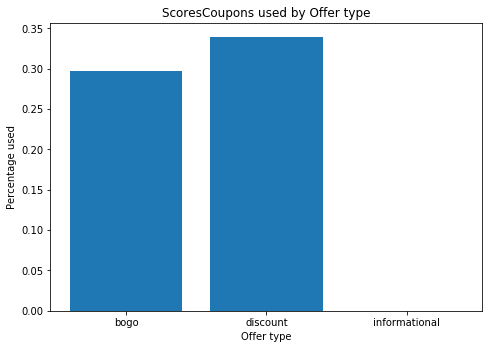

In [75]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
offer_types = offer_respond_df["offer_type"]
coupon_used = offer_respond_df["coupon_used"]
ax.bar(offer_types,coupon_used)
ax.set_xlabel('Offer type')
ax.set_ylabel('Percentage used')
ax.set_title('ScoresCoupons used by Offer type')
plt.show()

We see that discount offers are most influencing. Since informational offers don't have any minimum amount to complete offer, they don't have data for offer completed.

In [76]:
# Check the effect how different age groups are influenced by coupons.
person_age_df = person_offer_used_df[["age", "coupon_used"]][person_offer_used_df.coupon_used==True]

Text(0,0.5,'No of coupons used')

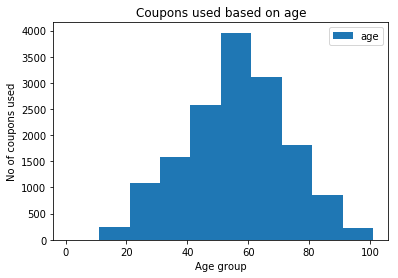

In [77]:
person_age_df.plot.hist(bins=10)
plt.title('Coupons used based on age')
plt.xlabel('Age group')
plt.ylabel('No of coupons used')

In [78]:
person_age_df.describe()

,age
count,15471.000000
mean,55.713141
std,16.658525
min,18.000000
25%,45.000000
50%,56.000000
75%,67.000000
max,101.000000


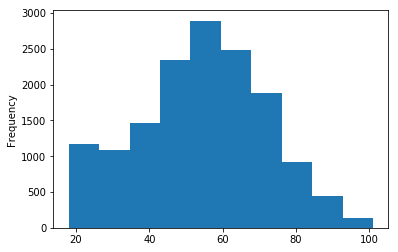

In [79]:
# Check for the age distribution in the profile dataframe.
profile["age"].plot.hist()

In [80]:
# Check how different income group users are effected by BOGO coupon.
person_income_df = person_offer_used_df[["income", "coupon_used"]][person_offer_used_df.offer_type == "bogo"][person_offer_used_df.coupon_used==True]



/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [81]:
person_income_df.head()

,income,coupon_used
0,100000.0,True
3,70000.0,True
35,33000.0,True
41,38000.0,True
44,92000.0,True


In [82]:
person_income_df.shape

(7527, 2)

Text(0,0.5,'No of BOGO coupons used')

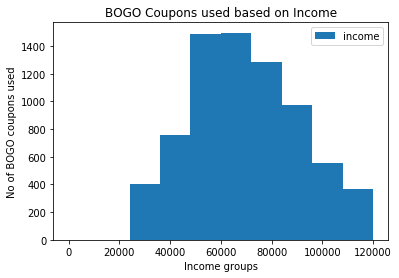

In [83]:
person_income_df.plot.hist(bins=10)
plt.title('BOGO Coupons used based on Income')
plt.xlabel('Income groups')
plt.ylabel('No of BOGO coupons used')

In [84]:
person_income_df.describe()

,income
count,7318.000000
mean,70004.099481
std,21210.065265
min,30000.000000
25%,54000.000000
50%,69000.000000
75%,85000.000000
max,120000.000000


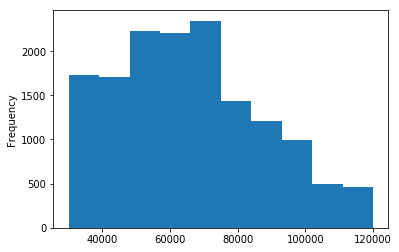

In [85]:
# Check for the income distribution in the profile dataframe.
profile["income"].plot.hist(bins=10)

In [86]:
profile["income"].describe()

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64